# 02 Neural Network classification with Pytorch

## 1. Make classification data and get it ready

In [504]:
import sklearn
from sklearn.datasets import make_circles, make_moons, make_blobs

In [505]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

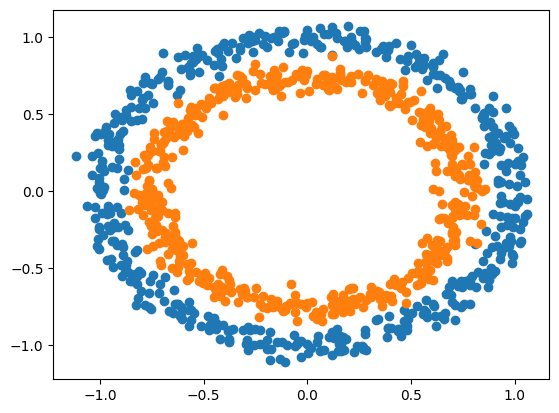

X: [[ 0.6939378   0.23364368]
 [-0.684698    0.16055978]
 [-0.78025298  0.21569233]
 [-0.40784663  0.62698884]
 [ 0.44560223 -0.89493556]], y: [1 1 1 1 0]


In [506]:
# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples, noise=0.05, random_state=42, factor=0.75)
# X, y = make_moons(n_samples, noise=0.05, random_state=42)

# plot data
def plot_data(X, y):
    plt.scatter(X[y==0, 0], X[y==0, 1])
    plt.scatter(X[y==1, 0], X[y==1, 1])
    plt.show()

plot_data(X, y)
print(f'X: {X[:5]}, y: {y[:5]}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [507]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [508]:
# Make dataframe of circled data
import pandas as pd
circles = pd.DataFrame({'X0': X[:, 0], 
                        'X1': X[:, 1], 
                        'label': y})

circles.head(5)



,X0,X1,label
0,0.693938,0.233644,1
1,-0.684698,0.160560,1
2,-0.780253,0.215692,1
3,-0.407847,0.626989,1
4,0.445602,-0.894936,0


### 1.1 check input and output shapes 

In [509]:
X.shape, y.shape

((1000, 2), (1000,))

In [510]:
# turn the data into tensors

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

print(f'X: {X[:5]}\n y: {y[:5]}')

X: tensor([[ 0.6939,  0.2336],
        [-0.6847,  0.1606],
        [-0.7803,  0.2157],
        [-0.4078,  0.6270],
        [ 0.4456, -0.8949]])
 y: tensor([1., 1., 1., 1., 0.])


In [511]:
# split data into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [512]:
len(X), len(X_train), len(X_test)

(1000, 800, 200)

### 2. Building a model

create a model that:

1. Subclasses `nn.Module`
2. Create 2 `nn.Linear()` layers with appropriate data shapes
3. Define a forward() method that outlines the forward pass
4. Instatiate an instance of our model class and send it to the target

In [513]:
class CircleModel_01(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 5)
        self.fc2 = nn.Linear(5, 1)
        
    def forward(self, X):
      return self.fc2(self.fc1(X))
    
#replicating the above model with nn.Sequential
    
model_0 = nn.Sequential(
    nn.Linear(2, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50,1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=1, bias=True)
)

In [514]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f'Lenght of untrained_preds: {len(untrained_preds)}, shape of untrained_preds: {untrained_preds.shape}')
print(f'length of test samples: {len(X_test)}, shape of test samples: {X_test.shape}')
print(f'\nFirst 10 predictions: {torch.round(untrained_preds[:10])}')
print(f'First 10 labels: {y[:10]}')
 

Lenght of untrained_preds: 200, shape of untrained_preds: torch.Size([200, 1])
length of test samples: 200, shape of test samples: torch.Size([200, 2])

First 10 predictions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)
First 10 labels: tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.])


In [515]:
# setting up the loss function and optimizer

# we have binary classification problem, so we use binary crossentropy loss

loss_fn = nn.BCEWithLogitsLoss() #sigmoid activation function is included in this loss function

# optimizer
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)



In [516]:
# Calculate accuracy 
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct / len(y_pred) * 100
  return acc


### 3.  Training model

To train the model we have to make a training loop

1. Forward pass
2. calc the loss
3. Optimize zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction table

Our model will output raw logits

We can convert them into pred prob by passing them to some kind og activation function (sigmoid in BinClass and SoftMax for MulticlassClass)

Then we convert itinto predction labels by for example rounding them to full numbers

In [517]:


model_0.eval()

with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:10]

y_logits

print(f'logits_max: {y_logits.max()}, logits_min: {y_logits.min()}')
  

logits_max: 0.11863863468170166, logits_min: 0.011767968535423279


In [518]:
#use the sigmoid activation function to convert logits to probabilities

# y_pred_probs = torch.sigmoid(y_logits)

# print(y_pred_probs)

# #round the probabilities to get the predicted labels

# y_pred_rounded = torch.round(y_pred_probs)

# print(y_pred_rounded)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))

print(f'First 10 predicted labels: {y_pred_labels[:10].squeeze()}')

First 10 predicted labels: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)


In [523]:
epochs = 100000

epoch_count = []
losses = []
accuracies = []

for epoch in range(epochs):
  model_0.train()
  
  # 1. Forward pass
  y_logits = model_0(X_train.to(device)).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> round to 0 or 1

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits,
                y_train.to(device))

  acc = accuracy_fn(y_true = y_train,
                    y_pred =  y_pred)
  
  # 3. Optimization

  optimizer.zero_grad()

  # 4. Backward pass (backpropagation)
  loss.backward()

  # 5. Update model
  optimizer.step()

  ### Test the model
  model_0.eval()
  with torch.inference_mode():
    # Forward pass
    y_logits_test = model_0(X_test.to(device)).squeeze()
    # Calculate loss/accuracy
    y_pred_test = torch.round(torch.sigmoid(y_logits_test))
    loss_test = loss_fn(y_logits_test, y_test.to(device))
    acc_test = accuracy_fn(y_test, y_pred_test)

  # Print the metrics
  if epoch % 10 == 0:
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss:.4f}, Accuracy: {acc:.4f}, Test loss: {loss_test:.4f}, Test accuracy: {acc_test:.4f}')

Epoch [0/100000], Loss: 0.0161, Accuracy: 99.8750, Test loss: 0.0548, Test accuracy: 98.0000
Epoch [10/100000], Loss: 0.0160, Accuracy: 99.8750, Test loss: 0.0548, Test accuracy: 98.0000
Epoch [20/100000], Loss: 0.0160, Accuracy: 99.8750, Test loss: 0.0548, Test accuracy: 98.0000
Epoch [30/100000], Loss: 0.0160, Accuracy: 99.8750, Test loss: 0.0548, Test accuracy: 98.0000
Epoch [40/100000], Loss: 0.0160, Accuracy: 99.8750, Test loss: 0.0548, Test accuracy: 98.0000
Epoch [50/100000], Loss: 0.0160, Accuracy: 99.8750, Test loss: 0.0548, Test accuracy: 98.0000
Epoch [60/100000], Loss: 0.0160, Accuracy: 99.8750, Test loss: 0.0547, Test accuracy: 98.0000
Epoch [70/100000], Loss: 0.0160, Accuracy: 99.8750, Test loss: 0.0547, Test accuracy: 98.0000
Epoch [80/100000], Loss: 0.0160, Accuracy: 99.8750, Test loss: 0.0547, Test accuracy: 98.0000
Epoch [90/100000], Loss: 0.0160, Accuracy: 99.8750, Test loss: 0.0547, Test accuracy: 98.0000
Epoch [100/100000], Loss: 0.0160, Accuracy: 99.8750, Test los

### 4. Make predictions and evaluate the model

From the metrics it looks like the model isn't learning anything (fixed, sike (lower learning rate, neurons from 5 to 10 per ayer, and ReLu in between))

Were making it visual using plot_decision_boundary, a custom, non pytorch function from mr youtuber bourke

In [520]:
# Deprecated, tensorflow no longer working on python 3.12

#
# import requests
# from pathlib import Path

# if Path("helper_functions.py").exists():
#   print("File exists")
# else:
#   url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
#   r = requests.get(url)
#   with open("helper_functions.py", "w") as file:
#     file.write(r.text)



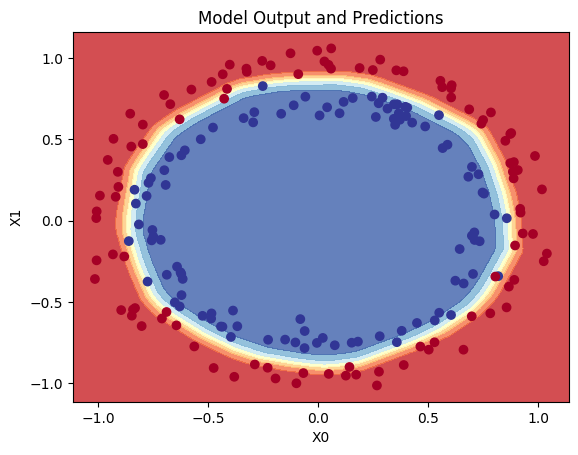

In [521]:
import numpy as np

def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    model.eval()
    with torch.inference_mode():
        Z = torch.sigmoid(model(grid.to(device))).detach().cpu().numpy().reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
    plt.xlabel('X0')
    plt.ylabel('X1')
    plt.title('Model Output and Predictions')
    plt.show()

plot_decision_boundary(model_0, X_test, y_test)


### 5. Improving a model (from a model perspective)

1. add more layers -0 give model more chances to learn about patterns in the data
2. Add more hidden units - go from 5 to 10 neurons ler layer
3. Fit for longer - number of epochs
4. Change the learning rate
5. change the loss functions 

Basically **Changing the hyperparameters**

Improving the model from data perspective includes:
1. more data - more samples 
2. better data - getting rid of outliers


### save the model, load again, and predict random data

Predictions:
the generated random samples: tensor([[-0.9934, -0.3109],
        [-0.3354, -0.7271],
        [ 0.3186, -0.5847],
        [-0.6218, -0.0330],
        [-0.7004,  0.5609],
        [ 0.5704, -0.3221],
        [ 0.0625, -0.5225],
        [-0.1279, -0.0113],
        [ 0.7408, -0.9902],
        [-0.2741, -0.9556]])
The prediction for the first 10 samples: tensor([0., 1., 1., 1., 0., 1., 1., 1., 0., 0.])


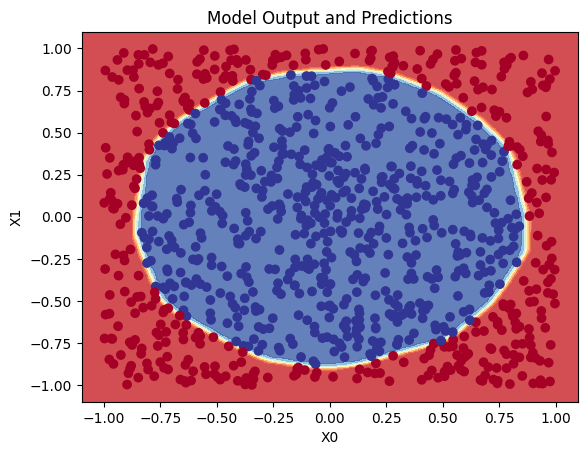

In [529]:
from pathlib import Path
# save the model
DIRECTORY = 'models'
if not Path(DIRECTORY).exists():
  Path(DIRECTORY).mkdir()
FILENAME = 'model_0_binary_classification_circles.pth'

torch.save(model_0, DIRECTORY + '/' + FILENAME)

# load the model

loaded_model = torch.load(DIRECTORY + '/' + FILENAME)

# Generate random data samples with x, y values between -1 and 1
random_samples = torch.rand((1000, 2)) * 2 - 1

# Make predictions with the model
loaded_model.eval()
with torch.inference_mode():
    predictions = torch.round(torch.sigmoid(loaded_model(random_samples.to(device))))

# Print the predictions
print("Predictions:")
print(f'the generated random samples: {random_samples[:10]}')
print(f'The prediction for the first 10 samples: {predictions[:10].squeeze()}')

# Plot the decision boundary
plot_decision_boundary(loaded_model, random_samples, predictions)



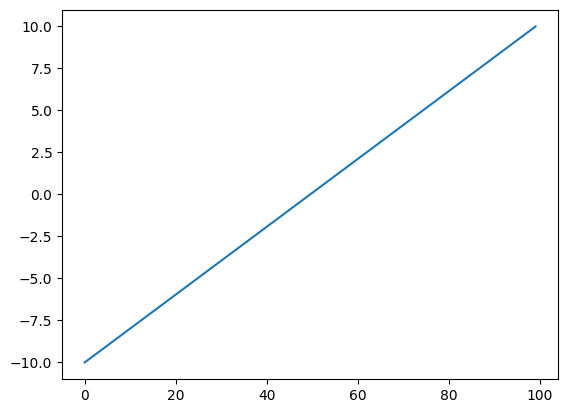

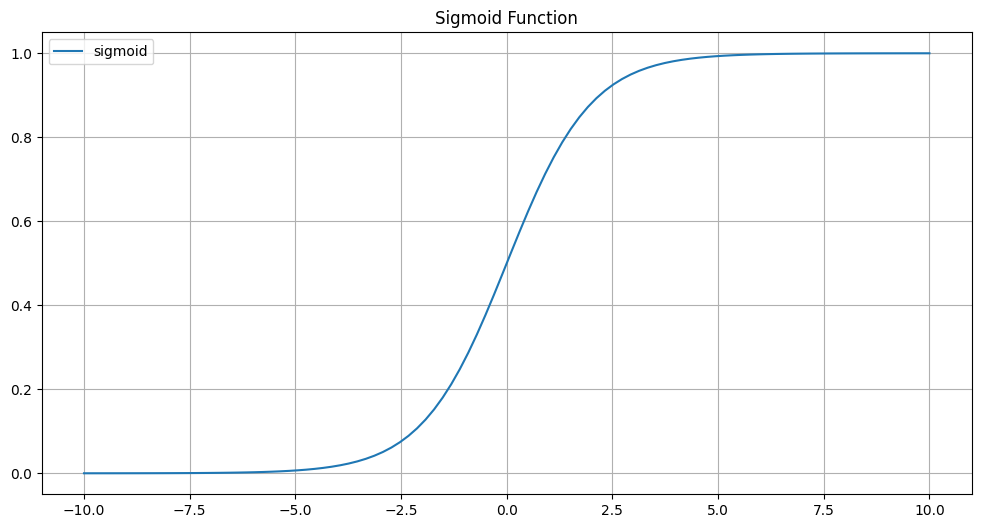

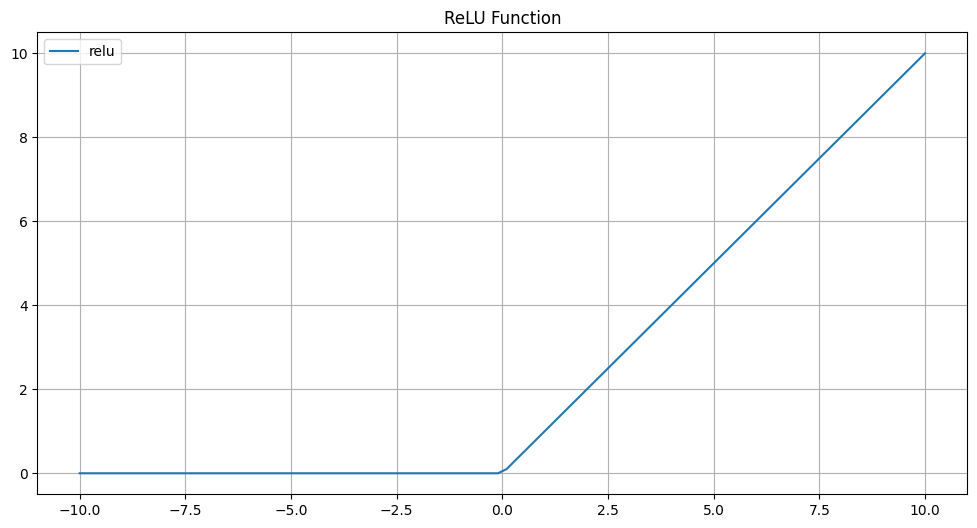

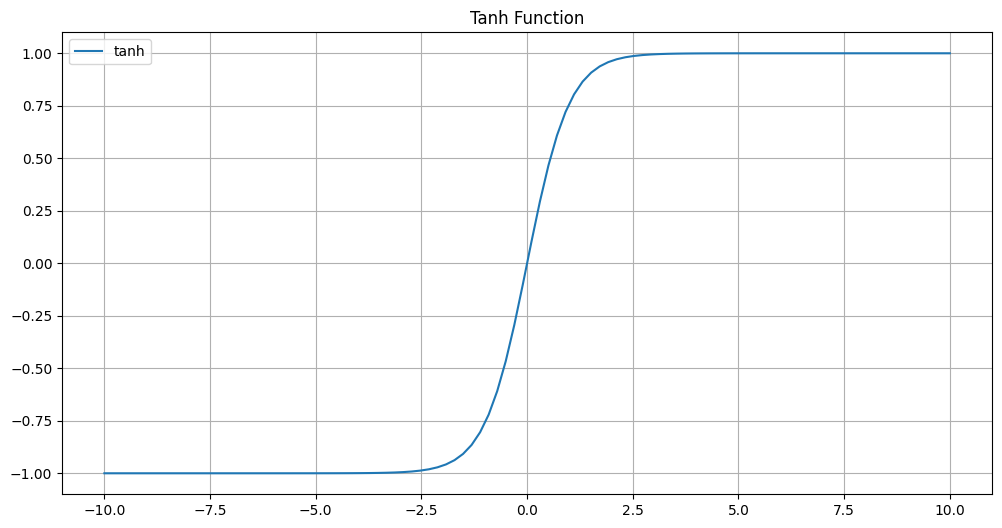

In [531]:
#Visualizing non linear activation functions

A = torch.linspace(-10, 10, 100)

def sigmoid(x):
  return 1/(1 + torch.exp(-x))

def relu(x):
  return torch.max(torch.tensor(0), x)

def tanh(x):
  return torch.tanh(x)

def plot_activation_function(x, y, title, function_name):
  plt.figure(figsize=(12, 6))
  plt.plot(x, y, label=function_name)
  plt.title(title)
  plt.legend()
  plt.grid(True)
  plt.show()

def display_activation_functions():
  plt.plot(A)
  plot_activation_function(A, sigmoid(A), 'Sigmoid Function', 'sigmoid')
  plot_activation_function(A, relu(A), 'ReLU Function', 'relu')
  plot_activation_function(A, tanh(A), 'Tanh Function', 'tanh')

display_activation_functions()
